In [1]:
from matplotlib import pyplot as plt   
import tensorflow as tf
import numpy as np
import cv2
from tqdm import tqdm

In [2]:
# Internal packages
from squat_buddy import SquatBuddy
from video import Video, Frame

In [3]:
sb = SquatBuddy()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [4]:
body_data, video = sb.process_video("test_images/IMG_2818.MOV")

Processing video from test_images/IMG_2818.MOV


In [6]:
sb.write_projections_to_video("test_images/IMG_2818.MOV")

Starting video processing
Processed frames


100%|██████████| 12/12 [00:00<00:00, 119.89it/s]


In [7]:
x_data, y_data, c_data, body_data_df = body_data.to_frame()

In [8]:
body_data_df

,x_nose,y_nose,c_nose,x_left_eye,y_left_eye,c_left_eye,x_right_eye,y_right_eye,c_right_eye,x_left_ear,...,c_left_knee,x_right_knee,y_right_knee,c_right_knee,x_left_ankle,y_left_ankle,c_left_ankle,x_right_ankle,y_right_ankle,c_right_ankle
0,0.004043,0.493759,0.478042,-0.003829,0.472133,0.339267,-0.003667,0.511401,0.337693,-0.000094,...,0.615379,0.659760,0.605750,0.714958,0.953692,0.369327,0.572775,0.957424,0.627037,0.661890
1,0.010213,0.490516,0.482080,0.003098,0.469564,0.345066,0.002467,0.507788,0.323823,0.009170,...,0.514539,0.660494,0.608943,0.766781,0.961862,0.367170,0.658783,0.950718,0.629338,0.659670
2,0.012858,0.488800,0.423187,0.007728,0.469574,0.400021,0.006624,0.504011,0.310005,0.014622,...,0.659080,0.658711,0.611579,0.744487,0.953808,0.367423,0.640431,0.949658,0.630545,0.679393
3,0.027327,0.496295,0.307507,0.021506,0.486811,0.361836,0.020547,0.503718,0.335103,0.033082,...,0.626123,0.662811,0.615468,0.693053,0.956849,0.370610,0.635316,0.953331,0.628148,0.634091
4,0.046497,0.492039,0.461468,0.041969,0.477051,0.300745,0.039402,0.500453,0.359405,0.058688,...,0.576149,0.660173,0.618636,0.600590,0.968374,0.369231,0.688036,0.957690,0.631265,0.557722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,0.001099,0.491076,0.518496,-0.007274,0.471915,0.287766,-0.005911,0.504762,0.332558,-0.009041,...,0.710077,0.645078,0.593123,0.829061,0.953516,0.369204,0.529416,0.959050,0.630698,0.630606
108,0.001694,0.491177,0.496926,-0.007281,0.471693,0.272515,-0.005872,0.504481,0.345699,-0.010879,...,0.738804,0.646958,0.592610,0.565773,0.952647,0.367552,0.543983,0.953092,0.629377,0.646133
109,-0.000361,0.488613,0.471005,-0.008692,0.468053,0.272810,-0.007761,0.504076,0.313165,-0.011768,...,0.713909,0.648339,0.593357,0.838063,0.951049,0.364074,0.574890,0.957942,0.629957,0.655885
110,-0.000385,0.490782,0.445824,-0.009268,0.470284,0.245793,-0.008022,0.505838,0.310849,-0.013891,...,0.723334,0.648537,0.591540,0.829798,0.951555,0.366088,0.550603,0.960349,0.630136,0.651971


In [40]:
body_data_df.to_csv('body_data_ex.csv')

In [10]:
body_data_df['frame'] = body_data_df.index.tolist()

In [38]:
lower_body_data = body_data_df[['x_left_hip', 'y_left_hip', 'c_left_hip', 'x_right_hip', 'y_right_hip',
       'c_right_hip', 'x_left_knee', 'y_left_knee', 'c_left_knee',
       'x_right_knee', 'y_right_knee', 'c_right_knee', 'x_left_ankle',
       'y_left_ankle', 'c_left_ankle', 'x_right_ankle', 'y_right_ankle',
       'c_right_ankle', 'frame', 'x_left_shoulder','y_left_shoulder', 'c_left_shoulder', 
       'x_right_shoulder','y_right_shoulder','c_right_shoulder',]]

In [12]:
def filter_by_confidence(df, col, conf_col, limit):
    filtered = df[[col, conf_col]]
    return filtered[filtered[conf_col] >= limit]

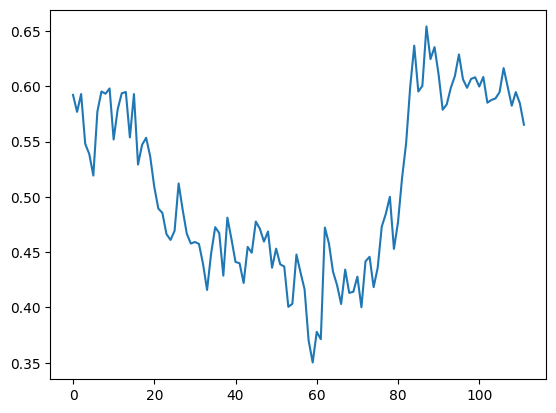

In [13]:
confidence_cols = [col for col in body_data_df.columns.tolist() if col[0:2] == "c_"]

confidence_df = body_data_df[confidence_cols]

avgs = [np.mean([confidence_df.iloc[i][c] for c in confidence_df.iloc[i].keys()]) for i in range(len(confidence_df))]

plt.plot(avgs)

In [49]:
vals = np.mean([confidence_df.iloc[0][c] for c in confidence_df.iloc[0].keys()])
vals

0.42160416

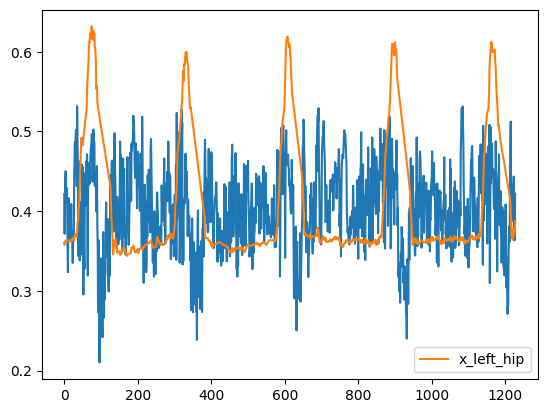

In [51]:
filtered_df = filter_by_confidence(lower_body_data, 'x_left_hip', 'c_left_hip', 0.5)
plt.plot(avgs)
plt.plot(filtered_df['x_left_hip'], label = 'x_left_hip')
plt.legend()

/var/folders/tc/97c6k8n53bl2l16np02v0sgh0000gn/T/ipykernel_78713/2090929376.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


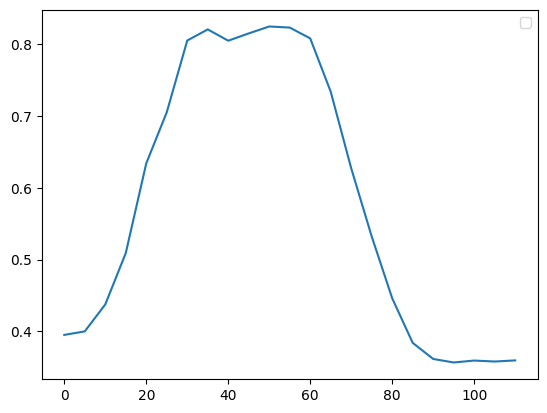

In [33]:
hip_mid = [(x1 + x2)/2 for x1, x2 in zip(lower_body_data['y_left_hip'], lower_body_data['y_right_hip'])]
# knee_mid = [(x1 + x2)/2 for x1, x2 in zip(lower_body_data['y_left_knee'], lower_body_data['y_right_knee'])]

plt.plot(lower_body_data['x_left_hip'][::5])
# plt.plot(knee_mid[::5])

plt.legend()

/var/folders/tc/97c6k8n53bl2l16np02v0sgh0000gn/T/ipykernel_78713/285359434.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


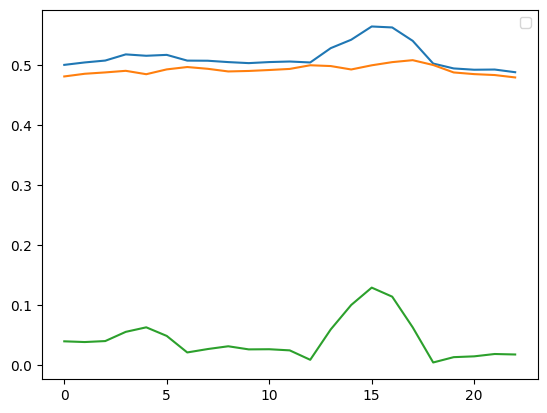

In [39]:
hip_mid = [(x1 + x2)/2 for x1, x2 in zip(lower_body_data['y_left_hip'], lower_body_data['y_right_hip'])]
knee_mid = [(x1 + x2)/2 for x1, x2 in zip(lower_body_data['y_left_shoulder'], lower_body_data['y_right_shoulder'])]

plt.plot(hip_mid[::5])
plt.plot(knee_mid[::5])

error = [abs(h - k)/k for h, k in zip(hip_mid[::5], knee_mid[::5])]
plt.plot(error)

plt.legend()

In [19]:
c_data

,nose,left_eye,right_eye,left_ear,right_ear,left_shoulder,right_shoulder,left_elbow,right_elbow,left_wrist,right_wrist,left_hip,right_hip,left_knee,right_knee,left_ankle,right_ankle
0,0.333385,0.452225,0.468535,0.441957,0.502453,0.363687,0.373827,0.186321,0.255543,0.253252,0.396052,0.584102,0.566269,0.589636,0.481176,0.535177,0.383674
1,0.323410,0.400843,0.356419,0.443516,0.488109,0.286998,0.336496,0.234526,0.214733,0.176895,0.311499,0.504714,0.482314,0.583751,0.438255,0.427972,0.308439
2,0.290420,0.435637,0.349787,0.492375,0.550497,0.329036,0.432259,0.299995,0.198475,0.431712,0.283707,0.429215,0.578910,0.486846,0.550308,0.388960,0.594735
3,0.349937,0.409591,0.355369,0.393907,0.491705,0.396562,0.489471,0.342200,0.243358,0.463460,0.291688,0.546156,0.649169,0.501479,0.543276,0.441976,0.656311
4,0.327075,0.383771,0.373582,0.342468,0.425753,0.397507,0.467985,0.346261,0.316491,0.458881,0.297518,0.581932,0.677050,0.536297,0.581450,0.467763,0.671578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1223,0.361655,0.392489,0.314339,0.370512,0.569857,0.292446,0.455924,0.373667,0.220286,0.495797,0.144740,0.528379,0.617033,0.592476,0.556697,0.580975,0.670659
1224,0.397135,0.284235,0.310279,0.396878,0.432274,0.287815,0.491762,0.248253,0.265895,0.218766,0.176667,0.548047,0.565186,0.595451,0.554251,0.580375,0.689382
1225,0.399092,0.347592,0.289505,0.430032,0.454231,0.210024,0.168172,0.261956,0.235749,0.230835,0.135583,0.395072,0.478930,0.392204,0.458651,0.625304,0.663652
1226,0.427806,0.307688,0.368566,0.446590,0.440985,0.390130,0.289104,0.260780,0.389625,0.169920,0.360844,0.510134,0.432120,0.525977,0.505804,0.477996,0.391361


In [3]:
sb.write_projections_to_video("test_images/IMG_2422.MOV")

Starting video processing
Processed frames


100%|██████████| 123/123 [00:00<00:00, 143.55it/s]
